In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 13.3 MB/s eta 0:00:00a 0:00:01


In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
import albumentations as A
from albumentations.pytorch import ToTensorV2
from keras import backend as keras
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
!kaggle datasets download -d pkdarabi/bone-fracture-detection-computer-vision-project
!unzip bone-fracture-detection-computer-vision-project.zip > /dev/null

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-fracture-detection-computer-vision-project
License(s): Attribution 4.0 International (CC BY 4.0)
100%|██████████████████████████████████████▉| 84.0M/84.1M [00:01<00:00, 103MB/s]
100%|██████████████████████████████████████| 84.1M/84.1M [00:01<00:00, 80.4MB/s]


In [6]:
train_images = '/content/santh/downloads/YOLOv5_datasets/images/train'
train_labels = '/content/santh/downloads/YOLOv5_datasets/labels/train'

test_images =  '/content/santh/downloads/YOLOv5_datasets/images/test'
test_labels = '/content/santh/downloads/YOLOv5_datasets/labels/test'

val_images = '/content/santh/downloads/YOLOv5_datasets/images/val'
val_labels = '/content/santh/downloads/YOLOv5_datasets/labels/val'

In [7]:
print('Number of train frames: ' + str(len(os.listdir(train_images))))
print('Number of train labels: ' + str(len(os.listdir(train_labels))))
print('Number of val frames: ' + str(len(os.listdir(val_images))))
print('Number of val labels: ' + str(len(os.listdir(val_labels))))
print('Number of test frames: ' + str(len(os.listdir(test_images))))
print('Number of test labels: ' + str(len(os.listdir(test_labels))))
print('Total frames: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))

Number of train frames: 3631
Number of train labels: 3631
Number of val frames: 348
Number of val labels: 348
Number of test frames: 169
Number of test labels: 3631
Total frames: 4148


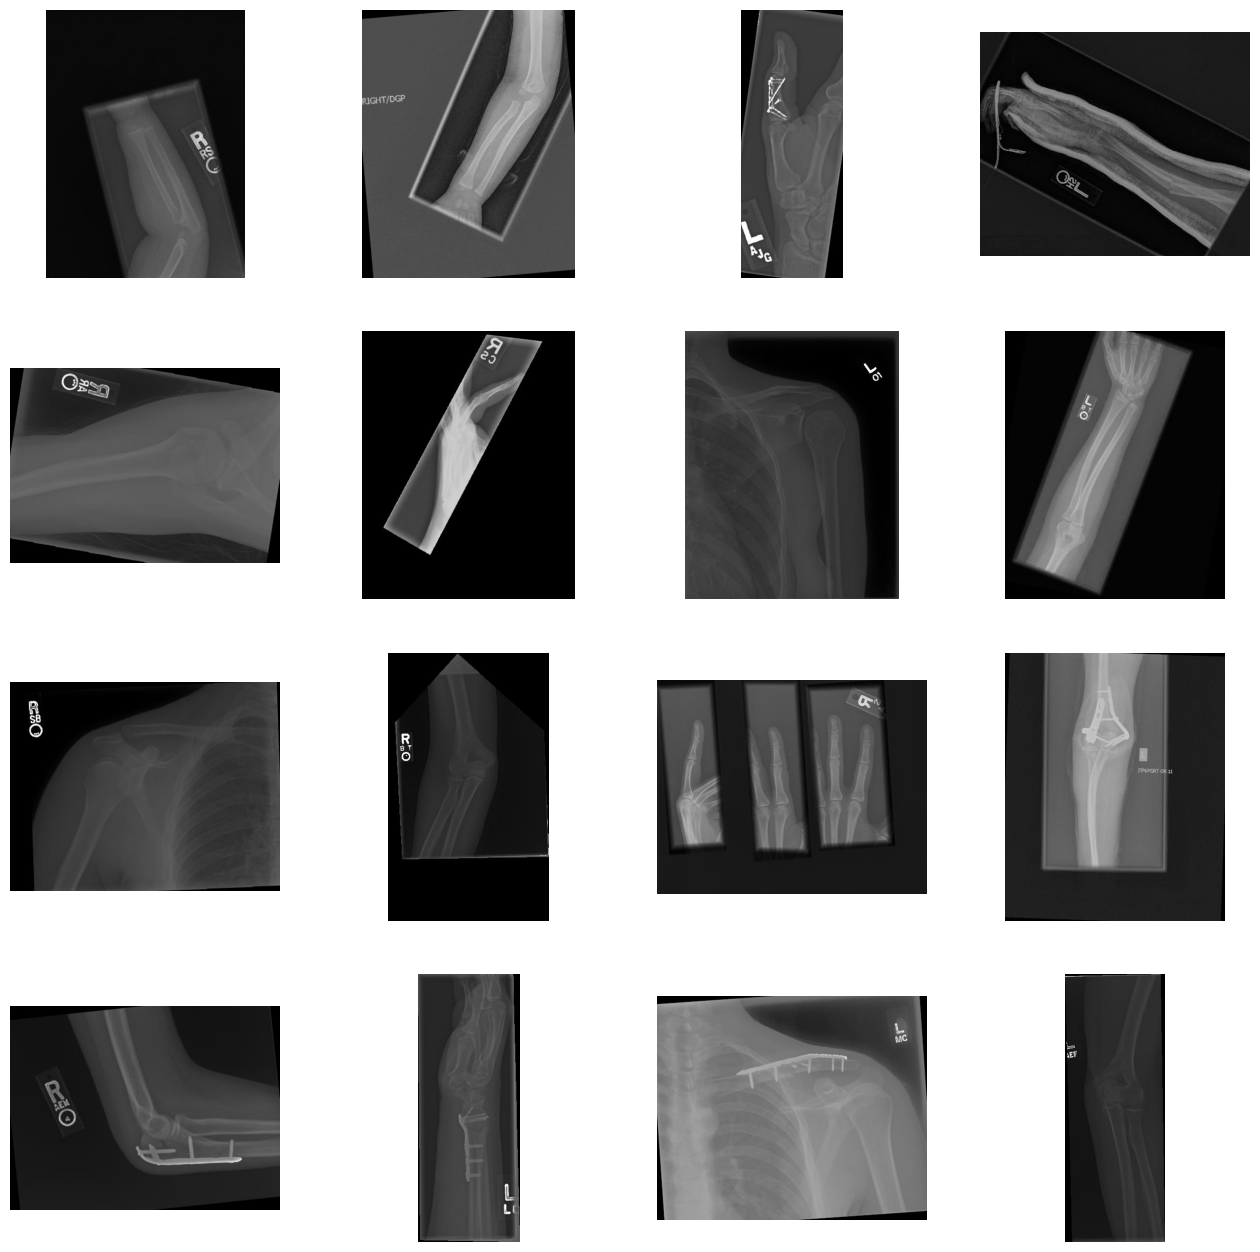

In [8]:
# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [9]:
# Loading a pretrained model
model = YOLO('yolov8s.pt')

# Training the model
model.train(data = '/content/santh/downloads/BoneFractureYolo8/data.yaml',
    epochs=60,
    seed=42,
    batch=16,
    imgsz=640,  # Image size
    augment=True,  # Enable augmentation
    flipud=0.5,    # Flip images upside down
    fliplr=0.5,    # Flip images left-right
    scale=0.5,     # Scaling
    shear=0.2,     # Shearing
    mosaic=1.0,    # Mosaic augmentation (set to 0.0 to disable)
    mixup=0.0      # Mixup augmentation (set to 0.0 to disable)
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 177MB/s]


Ultralytics YOLOv8.2.95 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

100%|██████████| 755k/755k [00:00<00:00, 12.1MB/s]
2024-09-17 11:00:59,869	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-17 11:01:00,453	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 74.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:13<00:00, 272.71it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:01<00:00, 310.81it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.68G      2.748      7.389      2.349         16        640: 100%|██████████| 227/227 [01:13<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]

                   all        348        204      0.404      0.047     0.0334     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.64G      2.493      3.995      2.172         18        640: 100%|██████████| 227/227 [01:10<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]


                   all        348        204      0.396     0.0383     0.0392     0.0119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.57G       2.49      3.799      2.182         19        640: 100%|██████████| 227/227 [01:09<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.30it/s]


                   all        348        204      0.449     0.0966     0.0649     0.0188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.62G      2.502      3.773      2.211         24        640: 100%|██████████| 227/227 [01:09<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.22it/s]


                   all        348        204        0.3     0.0622      0.064      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.57G      2.412      3.577      2.149         21        640: 100%|██████████| 227/227 [01:09<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.62it/s]


                   all        348        204      0.111     0.0968     0.0823     0.0301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.59G      2.362      3.377      2.102         12        640: 100%|██████████| 227/227 [01:09<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]

                   all        348        204      0.817       0.11      0.128     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.59G       2.31      3.248      2.074         20        640: 100%|██████████| 227/227 [01:08<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.89it/s]

                   all        348        204      0.243       0.18      0.158     0.0564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.61G      2.285      3.138      2.058         21        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.65it/s]


                   all        348        204      0.373      0.183      0.151     0.0546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.57G      2.219      3.003      2.026         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]


                   all        348        204      0.227      0.191      0.181     0.0637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.59G       2.19      2.941      1.978         13        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]


                   all        348        204      0.323      0.197      0.174      0.063

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.58G      2.173      2.865      1.966         26        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]

                   all        348        204      0.311      0.152      0.172     0.0616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      4.62G      2.149      2.835      1.953         17        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.76it/s]


                   all        348        204       0.52       0.22      0.195     0.0706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.57G      2.113      2.765      1.923         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]


                   all        348        204       0.33      0.234      0.198     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60       4.6G      2.106      2.689       1.94         17        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]

                   all        348        204       0.46       0.29      0.248     0.0935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.59G      2.108      2.663      1.938         19        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.50it/s]


                   all        348        204      0.301      0.235      0.221     0.0791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      4.61G      2.089      2.617      1.894         15        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.61it/s]


                   all        348        204      0.226      0.314       0.23     0.0892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.57G      2.044      2.558       1.89         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.85it/s]

                   all        348        204      0.259      0.266       0.22      0.082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60       4.6G      1.995      2.455      1.871         18        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]

                   all        348        204       0.25      0.311      0.232     0.0817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      4.58G      2.002      2.471      1.853         15        640: 100%|██████████| 227/227 [01:08<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]

                   all        348        204      0.278       0.29      0.242     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      4.61G      1.991      2.418      1.825         16        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.73it/s]


                   all        348        204      0.239      0.278      0.254     0.0985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.57G      1.968      2.297      1.821         16        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]

                   all        348        204      0.267      0.282      0.242     0.0854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.59G      1.947      2.256      1.809         15        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.66it/s]


                   all        348        204      0.351      0.249       0.24     0.0882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      4.59G      1.939      2.262      1.781         23        640: 100%|██████████| 227/227 [01:09<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]

                   all        348        204      0.375      0.254      0.257     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      4.61G      1.935      2.178      1.786         16        640: 100%|██████████| 227/227 [01:09<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]

                   all        348        204      0.312      0.365      0.265     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      4.57G      1.907       2.15      1.764         27        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]

                   all        348        204      0.236      0.283      0.222     0.0856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      4.64G      1.882      2.106      1.749         15        640: 100%|██████████| 227/227 [01:08<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.68it/s]


                   all        348        204      0.323      0.284      0.277      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      4.59G      1.879      2.079      1.759         16        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]

                   all        348        204      0.346      0.322      0.257     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      4.61G      1.823      1.929      1.714         14        640: 100%|██████████| 227/227 [01:08<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]

                   all        348        204      0.328      0.361      0.256     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      4.57G      1.842      1.952      1.718         11        640: 100%|██████████| 227/227 [01:08<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]

                   all        348        204      0.375      0.307      0.298      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.59G      1.792      1.912      1.685         15        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.41it/s]


                   all        348        204      0.248      0.307      0.259     0.0912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      4.58G      1.767      1.826      1.667         13        640: 100%|██████████| 227/227 [01:09<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.67it/s]


                   all        348        204      0.301      0.328      0.275     0.0945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      4.63G      1.764      1.805      1.677         16        640: 100%|██████████| 227/227 [01:09<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]

                   all        348        204      0.308      0.269       0.26     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      4.57G      1.752      1.792      1.659         22        640: 100%|██████████| 227/227 [01:09<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.67it/s]

                   all        348        204      0.293      0.351      0.253     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      4.59G        1.7      1.692       1.62         17        640: 100%|██████████| 227/227 [01:08<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]


                   all        348        204      0.285      0.347      0.304      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      4.58G       1.69      1.654      1.622          9        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]

                   all        348        204      0.323      0.317      0.271     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      4.63G      1.676      1.587      1.616         10        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.87it/s]

                   all        348        204      0.316      0.376      0.274     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      4.57G      1.655      1.592      1.584         16        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]

                   all        348        204      0.285      0.359      0.262      0.095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      4.59G      1.638      1.528      1.566         15        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.69it/s]


                   all        348        204      0.389      0.276      0.283      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.58G      1.611      1.504      1.555         18        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.96it/s]

                   all        348        204      0.366      0.357      0.296     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.62G      1.577      1.446      1.531         19        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.98it/s]

                   all        348        204      0.332       0.33      0.276      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      4.57G      1.576      1.399      1.525         17        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.94it/s]

                   all        348        204      0.423      0.304      0.295      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      4.58G       1.54      1.354      1.486         22        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]

                   all        348        204      0.326      0.272      0.253     0.0877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      4.63G      1.526      1.339      1.497         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.95it/s]

                   all        348        204      0.332      0.367      0.303      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      4.61G      1.507      1.275      1.479         10        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.99it/s]

                   all        348        204      0.369      0.318      0.278      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.56G      1.484      1.291      1.463          8        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.92it/s]

                   all        348        204      0.271       0.33      0.256     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60       4.6G      1.461      1.257      1.439          6        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.05it/s]

                   all        348        204      0.301      0.348      0.286      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60       4.6G      1.444      1.238      1.447         16        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]

                   all        348        204      0.458       0.23      0.281       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      4.61G      1.435      1.205      1.429         27        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]

                   all        348        204      0.289        0.3      0.278      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      4.57G      1.399      1.161      1.411         26        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]

                   all        348        204      0.328      0.298      0.284      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      4.64G      1.371      1.102       1.39         14        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.12it/s]

                   all        348        204       0.44      0.273      0.294      0.115


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      4.59G      1.319     0.9757       1.45         11        640: 100%|██████████| 227/227 [01:09<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]

                   all        348        204      0.343      0.274      0.261      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      4.61G      1.287     0.9033      1.423          9        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]

                   all        348        204      0.343      0.323      0.283        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      4.57G      1.241     0.8595      1.393          9        640: 100%|██████████| 227/227 [01:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.92it/s]

                   all        348        204      0.342      0.301      0.286      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      4.65G      1.231     0.8434      1.387          7        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.99it/s]

                   all        348        204       0.43      0.293      0.292      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      4.64G      1.213     0.8271      1.377          8        640: 100%|██████████| 227/227 [01:07<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.11it/s]

                   all        348        204      0.421      0.288      0.292      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.62G      1.198      0.807      1.359          5        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]

                   all        348        204      0.375      0.307      0.296      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      4.57G      1.181     0.7848      1.352          8        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]

                   all        348        204      0.458      0.259      0.296      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      4.59G      1.125     0.7463      1.303         14        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.06it/s]

                   all        348        204      0.513      0.288       0.31      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60       4.6G      1.119     0.7487      1.297         13        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]

                   all        348        204      0.457      0.279      0.288      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      4.62G      1.121     0.7211      1.299          8        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]

                   all        348        204      0.381      0.304      0.289       0.11



60 epochs completed in 1.209 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.95 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


                   all        348        204       0.36      0.357      0.312      0.122
        elbow positive         28         29       0.41      0.345      0.232     0.0576
      fingers positive         41         48      0.248      0.354      0.286      0.104
      forearm fracture         37         43      0.532      0.512      0.482      0.213
               humerus         31         36        0.6      0.611      0.611      0.256
     shoulder fracture         19         20      0.291      0.247      0.236     0.0969
        wrist positive         17         28     0.0791     0.0714     0.0246    0.00555
Speed: 0.1ms preprocess, 12.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
lr/pg1,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
lr/pg2,▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
metrics/mAP50(B),▁▁▂▂▄▄▅▄▅▆▆▆▆▇▆▇▆▇▇█▇▇█▇▇▇▇██▇▇▇▇█▇▇████
metrics/mAP50-95(B),▁▁▂▂▄▄▄▄▅▆▆▅▆▇▆▆▆▇▆▇▆▆▇▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇█
metrics/precision(B),▆▆▄▁▃▆▅▄▅▇▃▄▄▃▅▆▃▅▅▆▄▄▄▅▄▆▅▆▅▅▄▇▅▇▅▅▆▆█▅
metrics/recall(B),▁▁▂▂▄▄▄▃▅▆▇▆▆▆▅▆▆▆█▇▇▆█▇█▆▇▇█▇█▅▇▆▇▇▆▇▆█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cbed1d8abc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

Ultralytics YOLOv8.2.95 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<00:00, 649.10it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]


                   all        348        204      0.334      0.375      0.305      0.118
        elbow positive         28         29      0.321      0.345       0.22     0.0584
      fingers positive         41         48      0.263      0.375      0.279      0.106
      forearm fracture         37         43      0.488      0.512      0.463      0.192
               humerus         31         36       0.54      0.611      0.591      0.246
     shoulder fracture         19         20      0.325      0.338      0.246      0.101
        wrist positive         17         28     0.0697     0.0714     0.0287    0.00598
Speed: 0.1ms preprocess, 15.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2


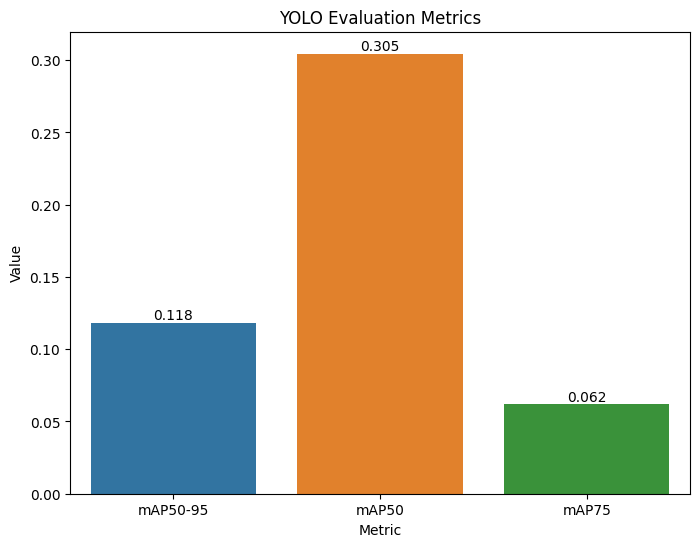

In [10]:
# After training, validate the model to get metrics
results = model.val(data='/content/santh/downloads/BoneFractureYolo8/data.yaml')

# Access evaluation metrics
map50_95 = results.box.map
map50 = results.box.map50
map75 = results.box.map75

# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[map50_95, map50, map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()



image 1/1 /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image1_3221_png.rf.5fb071486cc85c923cd8350b22ad6ee7.jpg: 640x352 1 elbow positive, 113.5ms
Speed: 2.1ms preprocess, 113.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 352)

image 1/1 /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image1_26_png.rf.ea3697c11878702d0b7728d240e2eb75.jpg: 320x640 (no detections), 28.8ms
Speed: 1.6ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image2_1718_png.rf.3320525501293fd17921dbca2ec70ebf.jpg: 544x640 1 forearm fracture, 1 shoulder fracture, 28.1ms
Speed: 2.5ms preprocess, 28.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image

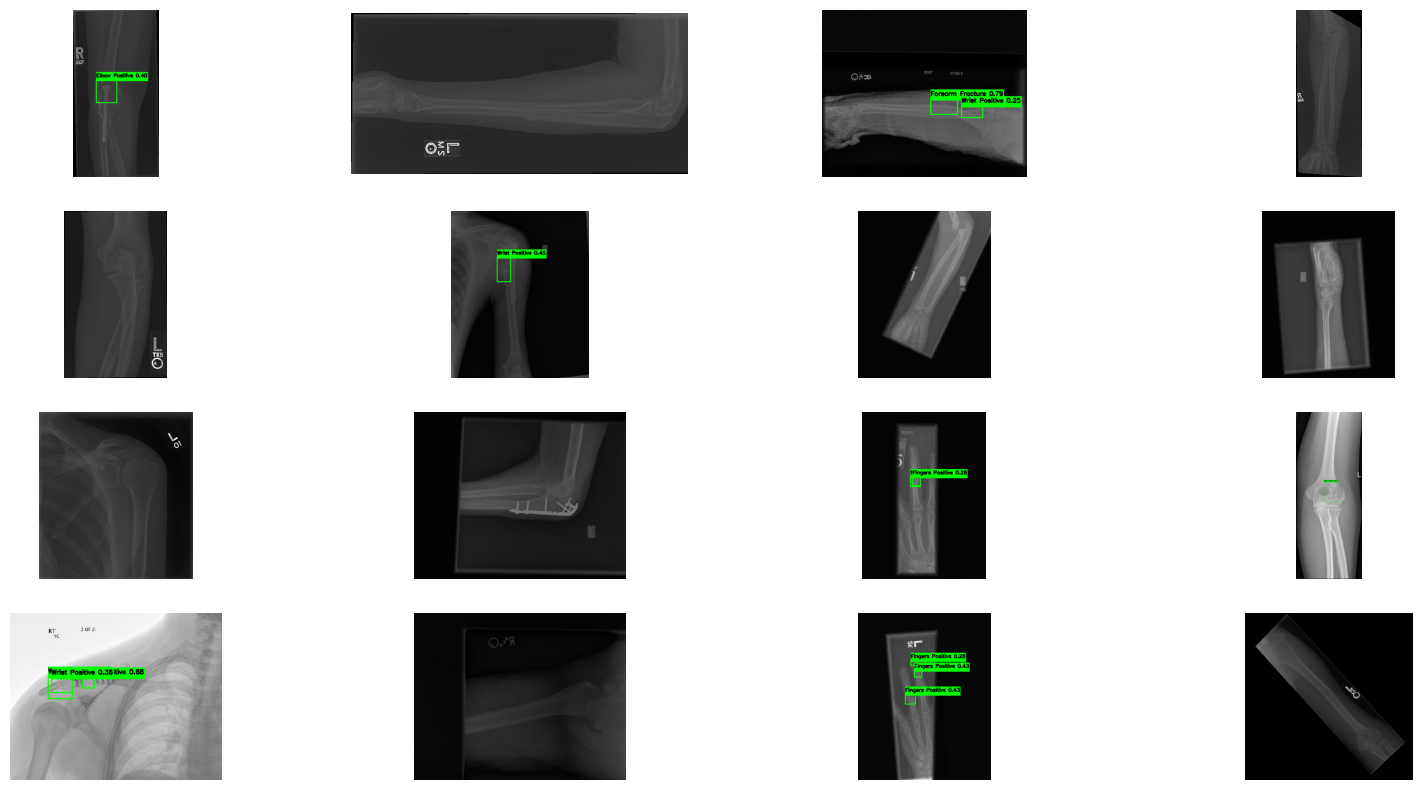

In [13]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import random
import cv2

# Load the class names (replace with the actual class names you have)
# Assuming the class names are listed in the same order as they appear in the label files
class_names = ['Elbow Positive', 'Fingers Positive', 'Forearm Fracture', 'Humerus Fracture', 'Shoulder Fracture', 'Wrist Positive']

# Path to test images directory
test_images_path = test_images

# Get a list of all the test image files
test_image_files = os.listdir(test_images_path)

# Select a random sample of test images to display
random_test_images = random.sample(test_image_files, 16)  # Adjust the number as needed

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(20, 10))  # Adjust the grid size based on the number of images

# Loop over the random images and display them with predictions
for i, image_file in enumerate(random_test_images):
    # Load the image
    image_path = os.path.join(test_images_path, image_file)
    image = cv2.imread(image_path)

    # Run the model's predict method on the image
    results = model.predict(source=image_path, show=False)  # Set show=True if running locally to see pop-up windows

    # Draw the bounding boxes on the image
    # `results` is an object that contains predictions, use its method to draw bounding boxes
    for result in results:
        # Iterate over each prediction
        for box in result.boxes:
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Bounding box coordinates
            class_id = int(box.cls[0])  # Extract class ID
            confidence = box.conf[0]  # Extract confidence score

            # Get the class name
            class_name = class_names[class_id]

            # Draw the bounding box
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green color, thickness=2

            # Draw the class name and confidence on the image
            label = f"{class_name} {confidence:.2f}"
            label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            label_ymin = max(y_min, label_size[1] + 10)
            cv2.rectangle(image, (x_min, label_ymin - label_size[1] - 10), (x_min + label_size[0], label_ymin + 5), (0, 255, 0), -1)
            cv2.putText(image, label, (x_min, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    # Plot the image with predictions
    row = i // 4
    col = i % 4
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

# Show the plot
plt.show()



image 1/1 /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image1_338_png.rf.617385aa69fa890a370a37684bae944f.jpg: 640x480 1 wrist positive, 28.6ms
Speed: 2.4ms preprocess, 28.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image1_4521_png.rf.9d460c80d2b830fc35b17c628a6d6290.jpg: 640x160 (no detections), 145.0ms
Speed: 0.9ms preprocess, 145.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 160)

image 1/1 /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image1_4966_png.rf.27ae131adff1063f606ceecb0fddc7c2.jpg: 640x512 2 shoulder fractures, 26.8ms
Speed: 2.2ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image1_186_png.rf.e7ef2

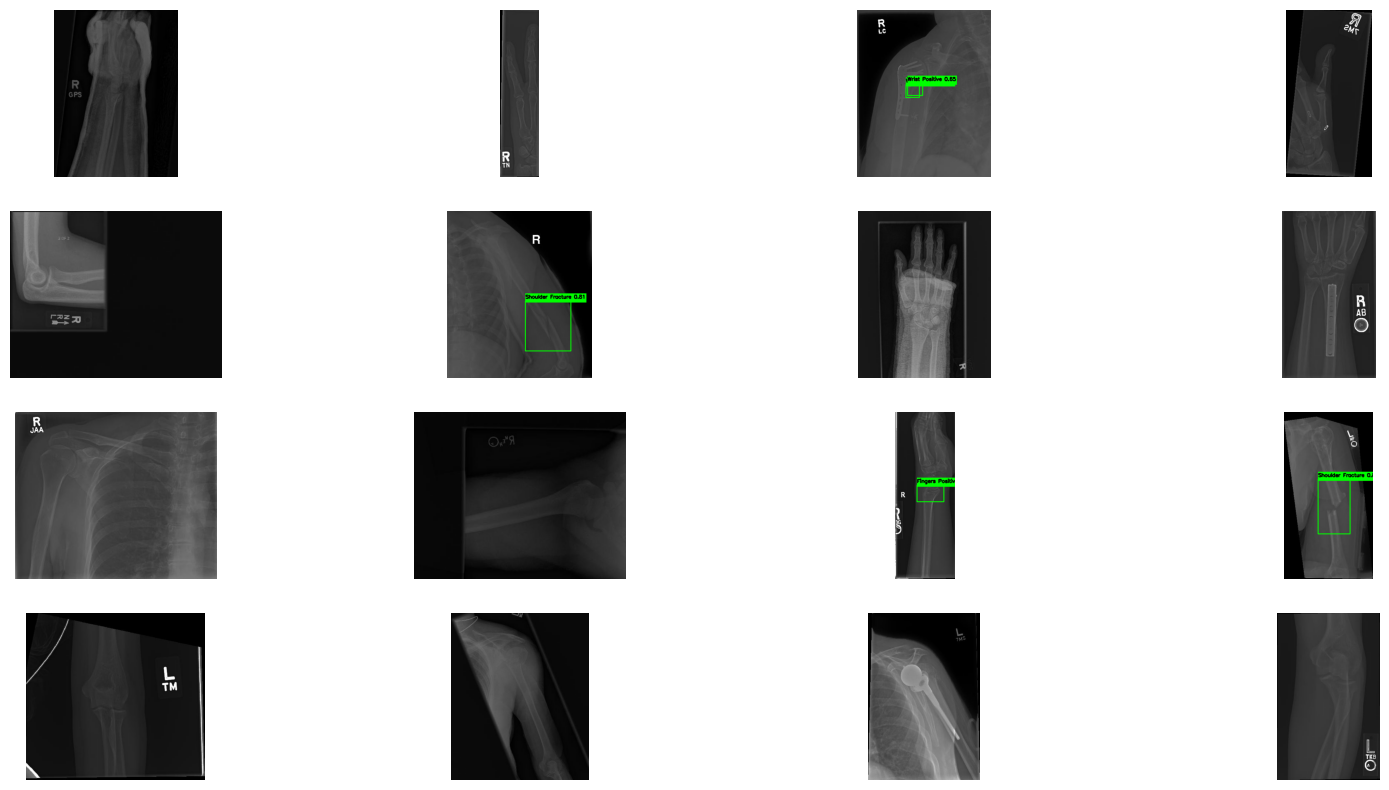

In [31]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import random
import cv2
import os

# Load the class names (replace with the actual class names you have)
class_names = ['Elbow Positive', 'Fingers Positive', 'Forearm Fracture', 'Humerus Fracture', 'Shoulder Fracture', 'Wrist Positive']

# Path to test images directory
test_images_path = '/content/santh/downloads/BoneFractureYolo8/test/images'

# Get a list of all the test image files
test_image_files = os.listdir(test_images_path)

# Select a random sample of test images to display
num_images_to_sample = min(16, len(test_image_files))  # Adjust the number as needed
random_test_images = random.sample(test_image_files, num_images_to_sample)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(20, 10))  # Adjust the grid size based on the number of images

# Confidence threshold
confidence_threshold = 0.5  # Adjust this value to set the desired confidence threshold

# Loop over the random images and display them with predictions
for i, image_file in enumerate(random_test_images):
    # Load the image
    image_path = os.path.join(test_images_path, image_file)
    image = cv2.imread(image_path)

    # Run the model's predict method on the image
    results = model.predict(source=image_path, show=False)  # Set show=True if running locally to see pop-up windows

    # Draw the bounding boxes on the image
    for result in results:
        # Iterate over each prediction
        for box in result.boxes:
            confidence = box.conf[0]  # Extract confidence score

            # Skip boxes with confidence below the threshold
            if confidence < confidence_threshold:
                continue

            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Bounding box coordinates
            class_id = int(box.cls[0])  # Extract class ID

            # Debugging information
            if class_id >= len(class_names):
                print(f"Warning: class_id {class_id} out of range for class_names list of length {len(class_names)}")

            # Ensure class_id is within range
            if class_id < len(class_names):
                # Get the class name
                class_name = class_names[class_id]

                # Draw the bounding box
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green color, thickness=2

                # Draw the class name and confidence on the image
                label = f"{class_name} {confidence:.2f}"
                label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
                label_ymin = max(y_min, label_size[1] + 10)
                cv2.rectangle(image, (x_min, label_ymin - label_size[1] - 10), (x_min + label_size[0], label_ymin + 5), (0, 255, 0), -1)
                cv2.putText(image, label, (x_min, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    # Plot the image with predictions
    row = i // 4
    col = i % 4
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

# Remove any unused subplots
for j in range(num_images_to_sample, 4 * 4):
    fig.delaxes(axs.flatten()[j])

# Show the plot
plt.show()
